In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_auc_score, f1_score, average_precision_score, fbeta_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, roc_curve
import shap
import sklearn
import joblib
#activate high interaction shell so print() is not necessary to show output. https://stackoverflow.com/questions/31764006/ipython-notebook-display-every-line-output-without-print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#CHOOSE THE MODEL TO FIT
#modelRunning = 'binaryModel'
modelRunning = 'multiClassModel'

#1. Get data
vmsOp2 = pd.read_csv('data/vmsOp2.csv')
vmsOp2 = vmsOp2.loc[vmsOp2['Date']>'2021-01-01'].copy()

if modelRunning == 'multiClassModel':
    print('MULTICLASS!')
    #2. Balance dataset between fishing operations (A, C, N)
    print('Unbalanced dataset structure:')
    vmsOp2.groupby('Operation').count()

    #sample same number of points as smallest category(C)
    n_bal = len(vmsOp2.loc[vmsOp2['Operation'] == 'C'])
    C_bal = vmsOp2.loc[vmsOp2['Operation']=='C'] #get all points for C
    A_bal = vmsOp2.loc[vmsOp2['Operation']=='A'].sample(n_bal)
    N_bal = vmsOp2.loc[vmsOp2['Operation']=='N'].sample(n_bal)

    print('Balanced dataset structure:')
    vmsOp2_bal = pd.concat([C_bal, A_bal, N_bal])
    vmsOp2_bal.groupby('Operation').count()

if modelRunning == 'binaryModel':
    print('BINARY!')
    binaryClasses = {'C':1, 'A':0, 'N':0}
    vmsOp2['Operation'] = vmsOp2['Operation'].replace(binaryClasses)
    vmsOp2.groupby('Operation').count()
    #sample same number of points as smallest category(1)
    n_bal = len(vmsOp2.loc[vmsOp2['Operation'] == 1])
    n_bal
    bal_1 = vmsOp2.loc[vmsOp2['Operation']==1] #get all points for 1
    bal_0 = vmsOp2.loc[vmsOp2['Operation']==0].sample(n_bal)
    print('Balanced dataset structure:')
    vmsOp2_bal = pd.concat([bal_1, bal_0])
    vmsOp2_bal.groupby('Operation').count()


BINARY!


C:\Users\jsala\AppData\Local\Temp\ipykernel_9892\607041550.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vmsOp2['Operation'] = vmsOp2['Operation'].replace(binaryClasses)


,Code,Date,Latitude,Longitude,geom,Speed,Course,CourseCorrected,TrackCode,Effort,...,IniDate,EndDate,DayTime,DayTime2,geometry,speedDiff-1,speedDiff+1,cogDiff,bufferGeom,bufferCount
Operation,,,,,,,,,,,,,,,,,,,,,
0,1557,1557,1557,1557,1557,1557,1557,1557,1557,1557,...,1557,1557,1557,1557,1557,1557,1557,1557,1557,1557
1,440,440,440,440,440,440,440,440,440,440,...,440,440,440,440,440,440,440,440,440,440


440

Balanced dataset structure:


,Code,Date,Latitude,Longitude,geom,Speed,Course,CourseCorrected,TrackCode,Effort,...,IniDate,EndDate,DayTime,DayTime2,geometry,speedDiff-1,speedDiff+1,cogDiff,bufferGeom,bufferCount
Operation,,,,,,,,,,,,,,,,,,,,,
0,440,440,440,440,440,440,440,440,440,440,...,440,440,440,440,440,440,440,440,440,440
1,440,440,440,440,440,440,440,440,440,440,...,440,440,440,440,440,440,440,440,440,440


In [11]:
#3. Split dataset into response (y) and predictive variables (x)
finalDF = vmsOp2_bal
finalDF.to_csv('data/' + modelRunning + '/balanced_dataset.csv')
x = finalDF[['Speed', 'CourseCorrected', 'cogDiff', 'speedDiff+1', 'speedDiff-1', 'DayTime2', 'bufferCount']]
y = finalDF.Operation

#encode labels 
le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
print('labels encoded as:')
dict(zip(le.classes_, le.transform(le.classes_)))

#4. Split x, y datasets into training and validation 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('vmsOp2 balanced total len: ' + str(len(finalDF)))
print('vmsOp2 balanced training len: ' + str(len(y_train)))
print('vmsOp2 balanced test len: ' + str(len(y_test)))

x_train.to_csv('data/' + modelRunning + '/x_train.csv', index=False)
y_train.to_csv('data/' + modelRunning + '/y_train.csv', index=False)
x_test.to_csv('data/' + modelRunning + '/x_test.csv', index=False)
y_test.to_csv('data/' + modelRunning + '/y_test.csv', index=False)

y_test.value_counts()

#5. Check preliminar model accuracy (without hyperparameter tunning)
model = RandomForestClassifier(n_estimators=300, max_features=1)
model.fit(x_train, y_train) 
print('The model accuracy in the training dataset is: ' + str(model.score(x_train, y_train)))
print('The model accuracy in the testing dataset is: ' + str(model.score(x_test, y_test)))


labels encoded as:


{0: 0, 1: 1}

vmsOp2 balanced total len: 880
vmsOp2 balanced training len: 660
vmsOp2 balanced test len: 220


0    112
1    108
Name: count, dtype: int64

RandomForestClassifier(max_features=1, n_estimators=300)

The model accuracy in the training dataset is: 1.0
The model accuracy in the testing dataset is: 0.8454545454545455


In [12]:
#6. Hyperparameter tunning
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num = 3)]
max_features = ['sqrt','log2']
max_depth = [2,3,5,10]
min_samples_split = [2,3,4,5] 
min_samples_leaf = [1,5,10,15,20]
bootstrap = [True, False]
max_leaf_nodes = [2,5,10,100, 1000]
min_impurity_decrease = [0.0, 0.1, 0.5, 1.0]
max_samples = [0.25, 0.5, 0.75, 1.0]
'''
max_features = ['sqrt','log2']
max_depth = [5]
min_samples_split = [5] 
min_samples_leaf = [15]
bootstrap = [True, False]
max_leaf_nodes = [10]
min_impurity_decrease = [0.0]
#max_samples = [0.25]
'''
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'max_leaf_nodes' : max_leaf_nodes,
              'min_impurity_decrease' : min_impurity_decrease,
              'max_samples' : max_samples
              }

scorers = {
    'precision_score': make_scorer(precision_score, average='micro')
    ,'recall_score': make_scorer(recall_score, average='micro')
    ,'f1_score': make_scorer(f1_score, average='micro')
    ,'accuracy_score': make_scorer(accuracy_score)
}

modelH = RandomForestClassifier(class_weight='balanced')
print('Fitting final model with hyperparameter tunning...')
rf_Grid = GridSearchCV(estimator = modelH, param_grid=param_grid, scoring=scorers, refit='accuracy_score', cv=5, verbose=1, n_jobs=10)
rf_Grid.fit(x_train, y_train)

print('Model best parameters:')
print(rf_Grid.best_params_)
print('\n Model accuracy in the training dataset is: ' + str(rf_Grid.score(x_train, y_train)))
print('Model accuracy in the test dataset: ' + str(rf_Grid.score(x_test, y_test)))

rf_Grid.best_estimator_.score
pd.DataFrame(rf_Grid.cv_results_).to_csv('results/' + modelRunning + '/gridSearchCV_results.csv')
joblib.dump(rf_Grid, 'results/' + modelRunning + '/fittedModel_' + modelRunning + '.pkl')


"\nmax_features = ['sqrt','log2']\nmax_depth = [5]\nmin_samples_split = [5] \nmin_samples_leaf = [15]\nbootstrap = [True, False]\nmax_leaf_nodes = [10]\nmin_impurity_decrease = [0.0]\n#max_samples = [0.25]\n"

Fitting final model with hyperparameter tunning...
Fitting 5 folds for each of 76800 candidates, totalling 384000 fits


c:\Users\jsala\anaconda3\envs\jupyter-env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
192000 fits failed out of a total of 384000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jsala\anaconda3\envs\jupyter-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jsala\anaconda3\envs\jupyter-env\Lib\site-packages\sklearn\ensemble\_forest.py", line 397, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

  war

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=10,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [2, 5, 10, 100, 1000],
                         'max_samples': [0.25, 0.5, 0.75, 1.0],
                         'min_impurity_decrease': [0.0, 0.1, 0.5, 1.0],
                         'min_samples_leaf': [1, 5, 10, 15, 20],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 1050, 2000]},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=micro),
                      'precision_score': make_scorer(precision_score, average=micro),
                      'recall_score': make_scorer(recall_score, average=micro)},
             verbose=1)

Model best parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 1000, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}

 Model accuracy in the training dataset is: 0.9257575757575758
Model accuracy in the test dataset: 0.8318181818181818


<bound method ClassifierMixin.score of RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', max_leaf_nodes=1000,
                       max_samples=0.5, min_samples_split=4)>

['results/binaryModel/fittedModel_binaryModel.pkl']

Accuracy of the final model is: 0.8318181818181818
                   AN           C
precision    0.826087    0.838095
recall       0.848214    0.814815
F-score      0.837004    0.826291
totals     112.000000  108.000000


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

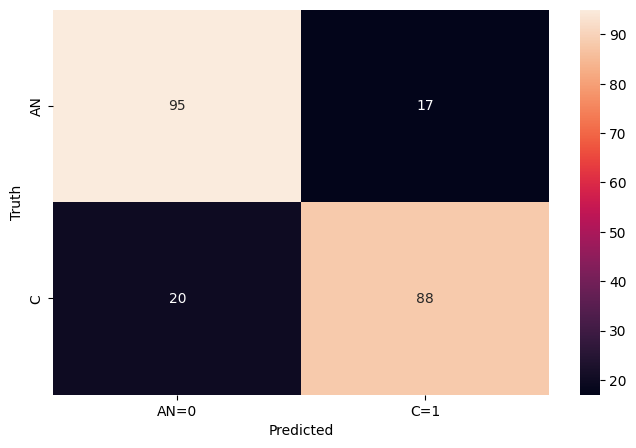

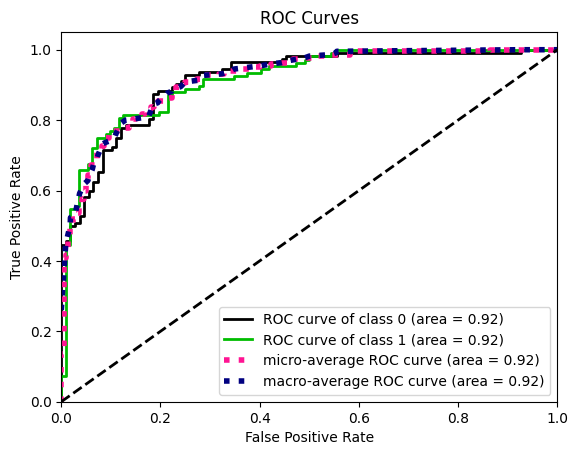

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

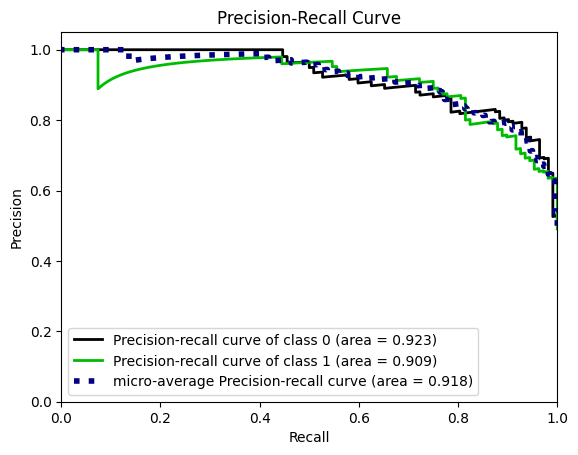

In [13]:
#from modelCheckFunctions import model_scoring_and_confusion_matrix_binaryModel
from modelCheckFunctions import *

#7. Check fitted model performance
#Get model predictions 
y_pred = rf_Grid.best_estimator_.predict(x_test)
y_score = rf_Grid.best_estimator_.predict_proba(x_test)

#Confusion matrix
if modelRunning == 'binaryModel': 
    model_scoring_and_confusion_matrix_binaryModel(y_test, y_pred)
if modelRunning == 'multiClassModel': 
    model_scoring_and_confusion_matrix_multiclassModel(y_test, y_pred)

#Roc curve
plot_roc(le.inverse_transform(y_test), y_score)
plt.show()

#Precision recall curve
plot_precision_recall(le.inverse_transform(y_test), y_score)
plt.show()